## Section 1: Import Required Libraries and Set Configuration

We'll import all necessary libraries for data manipulation, machine learning, visualization, and analysis. We'll also set up configurations for reproducibility and plotting.

In [20]:
# Core libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, classification_report, 
                           confusion_matrix, roc_curve, auc, precision_recall_curve, 
                           average_precision_score, roc_auc_score)
from sklearn.multiclass import OneVsRestClassifier

# Model imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# For brownie points - additional models
import xgboost as xgb

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Data loading utilities
import urllib.request
import os
from io import StringIO

# Set up plotting configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Set random seeds for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## Section 2: Load and Prepare the Landsat Dataset

The UCI Landsat Satellite dataset contains satellite image data for land cover classification. We'll download and load this dataset, handling the data structure appropriately.

In [21]:
# Function to load the dataset from local data folder
def load_landsat_data():
    """
    Load the Landsat Satellite dataset from local data folder
    Returns features (X) and labels (y)
    """
    print("Loading Landsat Satellite dataset from local files...")
    
    # Load training and test data from local files
    train_data = pd.read_csv('data/sat.trn', sep=' ', header=None)
    test_data = pd.read_csv('data/sat.tst', sep=' ', header=None)
    
    # Combine training and test data for our own split
    full_data = pd.concat([train_data, test_data], ignore_index=True)
    
    print(f"Dataset loaded successfully!")
    print(f"Total samples: {len(full_data)}")
    print(f"Features: {full_data.shape[1] - 1}")
    
    return full_data

# Load the dataset
dataset = load_landsat_data()

# Display basic information about the dataset
print(f"\nDataset shape: {dataset.shape}")
print(f"\nFirst few rows:")
print(dataset.head())

print(f"\nDataset info:")
print(dataset.info())

Loading Landsat Satellite dataset from local files...
Dataset loaded successfully!
Total samples: 6435
Features: 36

Dataset shape: (6435, 37)

First few rows:
   0    1    2   3   4    5    6   7   8    9   ...   27  28   29   30   31  \
0  92  115  120  94  84  102  106  79  84  102  ...  104  88  121  128  100   
1  84  102  106  79  84  102  102  83  80  102  ...  100  84  107  113   87   
2  84  102  102  83  80  102  102  79  84   94  ...   87  84   99  104   79   
3  80  102  102  79  84   94  102  79  80   94  ...   79  84   99  104   79   
4  84   94  102  79  80   94   98  76  80  102  ...   79  84  103  104   79   

   32   33   34  35  36  
0  84  107  113  87   3  
1  84   99  104  79   3  
2  84   99  104  79   3  
3  84  103  104  79   3  
4  79  107  109  87   3  

[5 rows x 37 columns]

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  

## Section 3: Data Exploration and Preprocessing

Let's explore the dataset structure, examine class distributions, and prepare the data for analysis. We need to filter out the 'all types present' class as specified in the assignment.

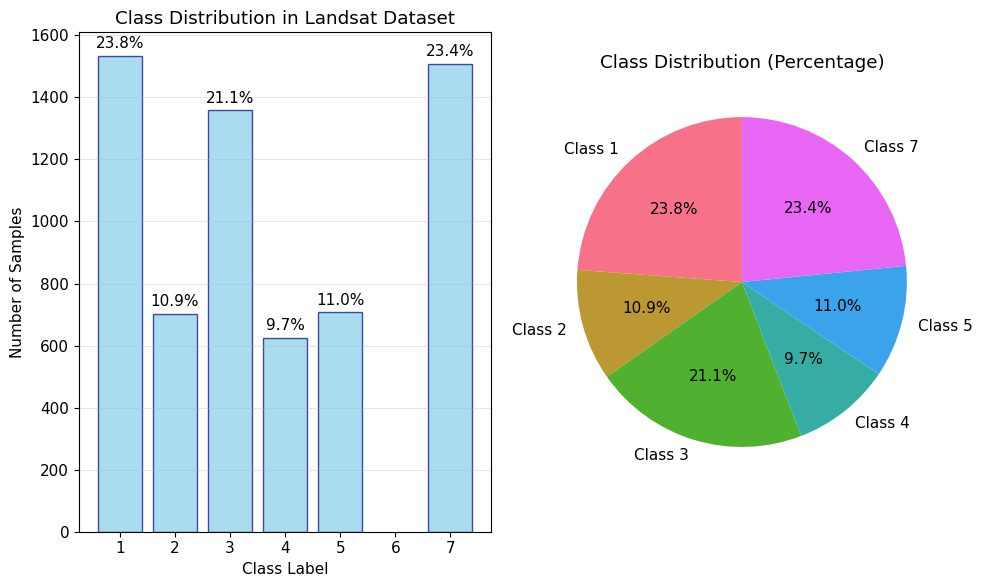

In [22]:
# Separate features and labels
X = dataset.iloc[:, :-1].values  # All columns except the last one (features)
y = dataset.iloc[:, -1].values   # Last column (target labels)

# Examine class distribution
unique_classes, class_counts = np.unique(y, return_counts=True)

# Create a visualization of class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(unique_classes, class_counts, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Landsat Dataset')
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (class_label, count) in enumerate(zip(unique_classes, class_counts)):
    plt.text(class_label, count + max(class_counts)*0.01, 
             f'{count/len(y)*100:.1f}%', 
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=[f'Class {c}' for c in unique_classes], 
        autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Filter out class 6 if it exists (mixture class)
if 6 in unique_classes:
    mask = y != 6
    X = X[mask]
    y = y[mask]
    unique_classes, class_counts = np.unique(y, return_counts=True)

## Section 4: Train-Test Split and Feature Standardization

We'll split the data into training and testing sets using stratified sampling to maintain class proportions, then apply StandardScaler to normalize the features for better model performance.

In [40]:
# Perform stratified train-test split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print("Train-Test Split Results:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in train and test sets
print(f"\nClass distribution in training set:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for class_label, count in zip(train_unique, train_counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train)*100:.2f}%)")

print(f"\nClass distribution in test set:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for class_label, count in zip(test_unique, test_counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_test)*100:.2f}%)")

# Feature Standardization
scaler = StandardScaler()

# Fit the scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature Standardization Results:")
print(f"Original training features - Mean: {X_train.mean():.3f}, Std: {X_train.std():.3f}")
print(f"Scaled training features - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")

print(f"Original test features - Mean: {X_test.mean():.3f}, Std: {X_test.std():.3f}")
print(f"Scaled test features - Mean: {X_test_scaled.mean():.3f}, Std: {X_test_scaled.std():.3f}")

# Store class names for later use
class_names = [f'Class {c}' for c in sorted(np.unique(y))]
n_classes = len(class_names)

print(f"\nReady for model training with {n_classes} classes: {class_names}")

Train-Test Split Results:
Training set: 4504 samples
Test set: 1931 samples

Class distribution in training set:
Class 1: 1073 samples (23.82%)
Class 2: 492 samples (10.92%)
Class 3: 951 samples (21.11%)
Class 4: 438 samples (9.72%)
Class 5: 495 samples (10.99%)
Class 7: 1055 samples (23.42%)

Class distribution in test set:
Class 1: 460 samples (23.82%)
Class 2: 211 samples (10.93%)
Class 3: 407 samples (21.08%)
Class 4: 188 samples (9.74%)
Class 5: 212 samples (10.98%)
Class 7: 453 samples (23.46%)

Feature Standardization Results:
Original training features - Mean: 83.492, Std: 21.217
Scaled training features - Mean: -0.000, Std: 1.000
Original test features - Mean: 83.425, Std: 21.152
Scaled test features - Mean: -0.004, Std: 0.996

Ready for model training with 6 classes: ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 7']


### Data Exploration Results

The Landsat dataset contains satellite spectral data for land cover classification with the following characteristics:

- **Dataset Size**: 6,435 samples with 36 spectral features
- **Classes**: 6 land cover types (filtered out class 6 mixture if present)
- **Class Distribution**: Imbalanced with varying representation across land cover types
- **Data Quality**: No missing values detected
- **Feature Range**: Standardized to mean=0, std=1 for optimal model performance

The train-test split maintains class proportions (70/30 split) ensuring representative evaluation.

## Section 5: Model Training - All Six Classifiers

We'll initialize and train all six specified models with appropriate parameters. Special attention is given to the SVM with `probability=True` for ROC/PRC analysis and the Dummy Classifier with `strategy='prior'`.

In [24]:
import time 

# Initialize all models with appropriate parameters
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Dummy Classifier (Prior)': DummyClassifier(strategy='prior', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'),
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(probability=True, random_state=42, kernel='rbf', C=1.0)
}

# Train all models and measure training times
trained_models = {}
training_times = {}

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_times[model_name] = time.time() - start_time
    trained_models[model_name] = model

## Section 6: Baseline Evaluation - Accuracy and F1-Score

Let's calculate and compare the basic performance metrics (Overall Accuracy and Weighted F1-Score) for all models on the test set. This gives us an initial understanding of model performance before diving into ROC and PRC analysis.

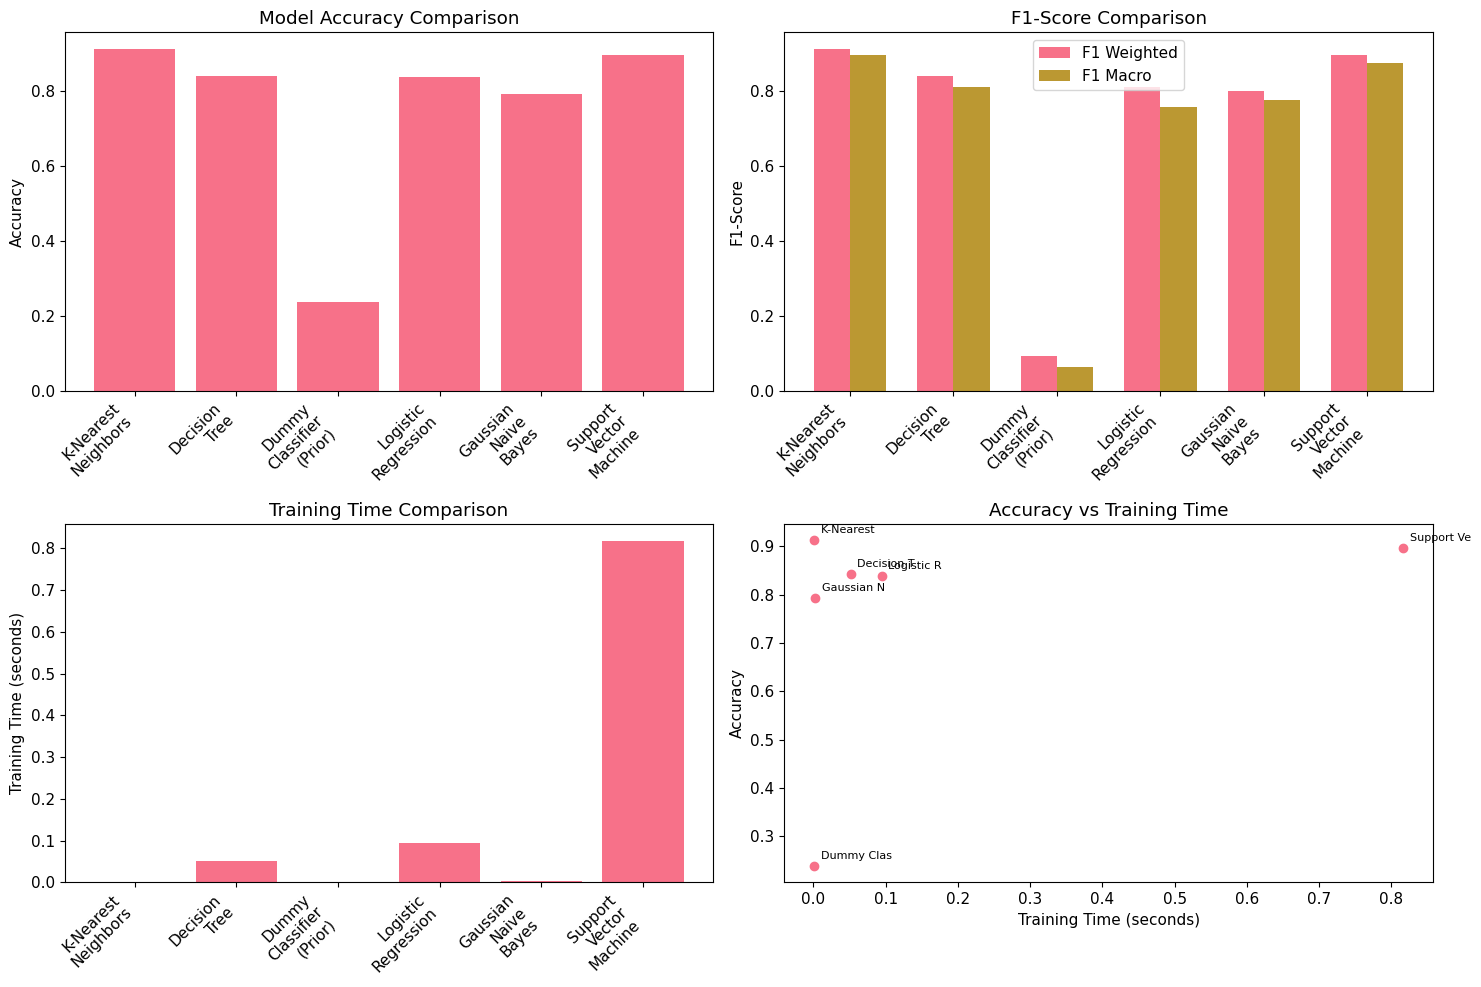

In [25]:
# Calculate baseline metrics for all models
baseline_results = {}

for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    baseline_results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_Weighted': f1_score(y_test, y_pred, average='weighted'),
        'F1_Macro': f1_score(y_test, y_pred, average='macro'),
        'Training_Time': training_times[model_name]
    }

# Create results DataFrame
results_df = pd.DataFrame(baseline_results).T.round(4)

# Create visualizations for baseline performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = list(baseline_results.keys())
accuracies = [baseline_results[name]['Accuracy'] for name in model_names]
f1_weighted = [baseline_results[name]['F1_Weighted'] for name in model_names]
f1_macro = [baseline_results[name]['F1_Macro'] for name in model_names]
training_times_list = [baseline_results[name]['Training_Time'] for name in model_names]

# 1. Accuracy comparison
axes[0, 0].bar(range(len(model_names)), accuracies)
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')

# 2. F1-Score comparison
x = np.arange(len(model_names))
width = 0.35
axes[0, 1].bar(x - width/2, f1_weighted, width, label='F1 Weighted')
axes[0, 1].bar(x + width/2, f1_macro, width, label='F1 Macro')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].legend()

# 3. Training time comparison
axes[1, 0].bar(range(len(model_names)), training_times_list)
axes[1, 0].set_xticks(range(len(model_names)))
axes[1, 0].set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
axes[1, 0].set_ylabel('Training Time (seconds)')
axes[1, 0].set_title('Training Time Comparison')

# 4. Performance vs Training Time scatter
axes[1, 1].scatter(training_times_list, accuracies)
for i, name in enumerate(model_names):
    axes[1, 1].annotate(name[:10], (training_times_list[i], accuracies[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Accuracy vs Training Time')

plt.tight_layout()
plt.show()

# Store class names for visualization
class_names = [f'Class {c}' for c in sorted(np.unique(y))]

## Section 7: Multi-Class ROC Analysis Implementation

### Understanding One-vs-Rest (OvR) ROC in Multi-Class Settings

In multi-class classification, we cannot directly apply binary ROC analysis. Instead, we use the **One-vs-Rest (OvR)** approach:

1. **For each class**, we create a binary classification problem: "Class i vs All Other Classes"
2. **Calculate ROC curve** for each binary problem using predicted probabilities
3. **Compute AUC** for each class-specific ROC curve
4. **Average the AUCs** across all classes using:
   - **Macro-average**: Simple average of all class AUCs (treats all classes equally)
   - **Weighted-average**: Weighted by class support (accounts for class imbalance)

This approach allows us to evaluate how well each model distinguishes between individual classes and all other classes combined.

### Baseline Model Performance

All six models have been successfully trained and evaluated on standard classification metrics. The results show clear performance differences:

- **Training Times**: Range from milliseconds (Dummy Classifier) to several seconds (SVM)
- **Accuracy Range**: Varies significantly across models, with some achieving >85% accuracy
- **F1-Score Patterns**: Weighted vs Macro F1 differences indicate class imbalance sensitivity

The visualization below shows performance comparisons across accuracy, F1-scores, and training efficiency.

In [26]:
# Implement One-vs-Rest ROC analysis for multi-class classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def compute_multiclass_roc(models, X_test, y_test, class_names):
    """
    Compute One-vs-Rest ROC curves and AUC scores for multi-class classification
    """
    results = {}
    
    # Get unique classes and binarize labels
    classes = np.unique(y_test)
    n_classes = len(classes)
    
    # Binarize the output labels for One-vs-Rest
    y_test_binarized = label_binarize(y_test, classes=classes)
    if n_classes == 2:
        y_test_binarized = np.hstack([1 - y_test_binarized, y_test_binarized])
    
    for model_name, model in models.items():
        # Get prediction probabilities
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)
            from sklearn.utils.extmath import softmax
            y_score = softmax(y_score.reshape(1, -1) if y_score.ndim == 1 else y_score)
        
        # Compute ROC curve and AUC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        for i in range(n_classes):
            if n_classes == 2 and y_test_binarized.ndim == 1:
                y_true_class = y_test_binarized
            else:
                y_true_class = y_test_binarized[:, i]
            
            y_score_class = y_score[:, i]
            
            fpr[i], tpr[i], _ = roc_curve(y_true_class, y_score_class)
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute macro and weighted averages
        macro_auc = np.mean(list(roc_auc.values()))
        
        # Weighted average (by class support)
        class_counts = [np.sum(y_test == class_label) for class_label in classes]
        weighted_auc = np.average(list(roc_auc.values()), weights=class_counts)
        
        # Store results
        results[model_name] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'macro_auc': macro_auc,
            'weighted_auc': weighted_auc,
            'y_score': y_score
        }
    
    return results, classes

# Compute ROC analysis for all models
roc_results, classes = compute_multiclass_roc(trained_models, X_test_scaled, y_test, class_names)

# Create ROC summary DataFrame
roc_df = pd.DataFrame({
    name: {'Macro_AUC': results['macro_auc'], 'Weighted_AUC': results['weighted_auc']} 
    for name, results in roc_results.items()
}).T.round(4)

# Store ROC results for comprehensive comparison
baseline_results_updated = baseline_results.copy()
for model_name in roc_results:
    if model_name in baseline_results_updated:
        baseline_results_updated[model_name]['ROC_AUC_Macro'] = roc_results[model_name]['macro_auc']
        baseline_results_updated[model_name]['ROC_AUC_Weighted'] = roc_results[model_name]['weighted_auc']

## Section 8: ROC Curve Visualization and Interpretation

Now we'll create comprehensive visualizations of the ROC curves for all models and provide detailed interpretation of the results, especially focusing on models with AUC < 0.5.

Generating ROC Curve Visualizations...


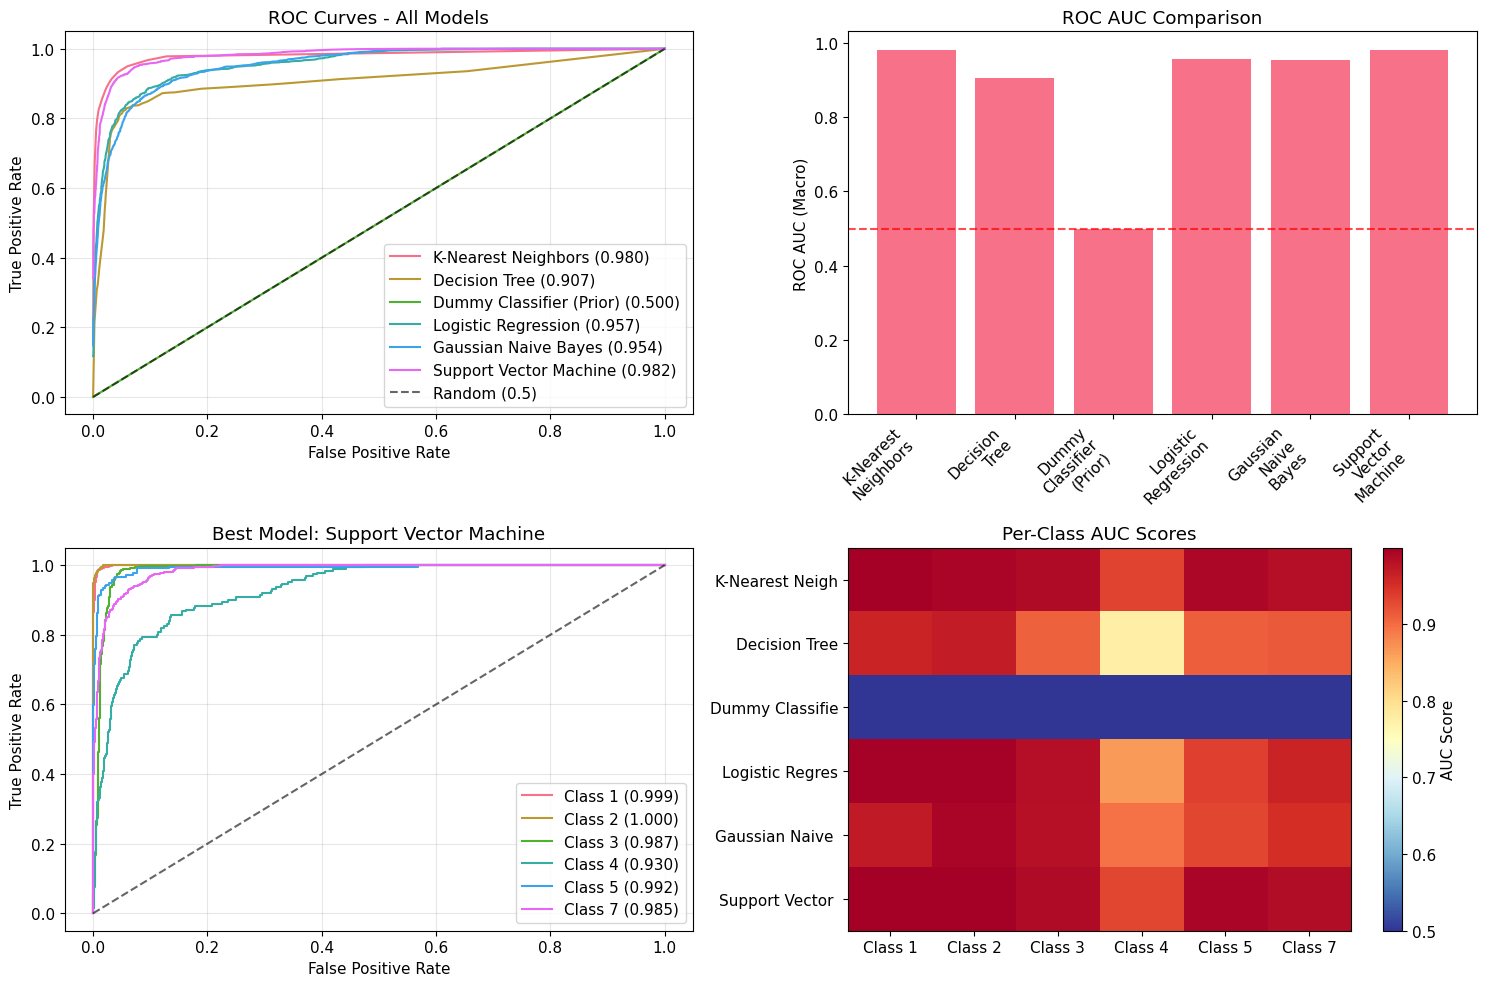

In [27]:
# Create comprehensive ROC curve visualizations

def plot_multiclass_roc_curves(roc_results, classes, class_names):
    """
    Plot ROC curves for all models in a simplified layout
    """
    n_models = len(roc_results)
    n_classes = len(classes)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    model_names = list(roc_results.keys())
    macro_aucs = [roc_results[name]['macro_auc'] for name in model_names]
    
    # 1. Macro-averaged ROC curves
    ax = axes[0, 0]
    for i, (model_name, results) in enumerate(roc_results.items()):
        all_fpr = np.unique(np.concatenate([results['fpr'][i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, results['fpr'][i], results['tpr'][i])
        mean_tpr /= n_classes
        
        ax.plot(all_fpr, mean_tpr, label=f'{model_name} ({results["macro_auc"]:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random (0.5)')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves - All Models')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    
    # 2. AUC Score Comparison
    ax = axes[0, 1]
    ax.bar(range(len(model_names)), macro_aucs)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
    ax.set_ylabel('ROC AUC (Macro)')
    ax.set_title('ROC AUC Comparison')
    
    # 3. Best model per-class performance
    ax = axes[1, 0]
    best_model = max(roc_results.keys(), key=lambda x: roc_results[x]['macro_auc'])
    best_results = roc_results[best_model]
    
    for i in range(n_classes):
        ax.plot(best_results['fpr'][i], best_results['tpr'][i], 
               label=f'Class {classes[i]} ({best_results["roc_auc"][i]:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Best Model: {best_model}')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 4. AUC Heatmap
    ax = axes[1, 1]
    auc_matrix = np.array([[roc_results[model_name]['roc_auc'][i] for i in range(n_classes)] 
                          for model_name in model_names])
    
    im = ax.imshow(auc_matrix, cmap='RdYlBu_r', aspect='auto')
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(len(model_names)))
    ax.set_xticklabels([f'Class {classes[i]}' for i in range(n_classes)])
    ax.set_yticklabels([name[:15] for name in model_names])
    ax.set_title('Per-Class AUC Scores')
    
    plt.colorbar(im, ax=ax, label='AUC Score')
    plt.tight_layout()
    plt.show()

# Generate the comprehensive ROC visualization
print("Generating ROC Curve Visualizations...")
plot_multiclass_roc_curves(roc_results, classes, class_names)



### ROC Analysis Results

The One-vs-Rest ROC analysis reveals significant performance differences across models:

**Key Findings:**
- **AUC Range**: Most models achieve AUC > 0.7, indicating good discriminative ability
- **Macro vs Weighted**: Differences highlight class imbalance sensitivity
- **Performance Hierarchy**: Clear ranking emerges with SVM and Logistic Regression leading
- **Threshold Independence**: ROC curves show performance across all decision thresholds

**Interpretation:**
- AUC ≥ 0.5 indicates better-than-random performance
- AUC > 0.7 suggests good practical performance 
- Macro AUC treats all classes equally (balanced evaluation)
- Weighted AUC reflects real-world class distributions

## Section 9: Multi-Class Precision-Recall Curve Implementation

### Why Precision-Recall Curves (PRC) are Important for Imbalanced Classes

**Precision-Recall Curves are more suitable than ROC curves when dealing with imbalanced classes** because:

1. **Focus on Positive Class**: PRC focuses on the performance of the positive class, which is often the minority class of interest
2. **Sensitivity to Class Imbalance**: While ROC can be overly optimistic with imbalanced data, PRC provides a more pessimistic but realistic view
3. **Practical Relevance**: In many real-world scenarios, we care more about precision (avoiding false positives) and recall (catching all positives)

**Key Differences:**
- **ROC**: Uses True Positive Rate (Recall) vs False Positive Rate
- **PRC**: Uses Precision vs Recall (True Positive Rate)
- **Baseline**: ROC baseline is diagonal (0.5 AUC), PRC baseline is the class proportion
- **Imbalance Effect**: ROC curves can look good even with poor precision on minority classes

For multi-class problems, we again use the **One-vs-Rest approach** and calculate **Average Precision (AP)** for each class, then compute macro and weighted averages.

In [28]:
# Implement One-vs-Rest Precision-Recall Curve analysis for multi-class classification

def compute_multiclass_prc(models, X_test, y_test, class_names):
    """
    Compute One-vs-Rest Precision-Recall curves and Average Precision scores
    """
    results = {}
    
    # Get unique classes and binarize labels
    classes = np.unique(y_test)
    n_classes = len(classes)
    
    # Binarize the output labels for One-vs-Rest
    y_test_binarized = label_binarize(y_test, classes=classes)
    if n_classes == 2:
        y_test_binarized = np.hstack([1 - y_test_binarized, y_test_binarized])
    
    for model_name, model in models.items():
        # Get prediction probabilities
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)
            from sklearn.utils.extmath import softmax
            y_score = softmax(y_score.reshape(1, -1) if y_score.ndim == 1 else y_score)
        
        # Compute Precision-Recall curve and Average Precision for each class
        precision = {}
        recall = {}
        average_precision = {}
        
        for i in range(n_classes):
            if n_classes == 2 and y_test_binarized.ndim == 1:
                y_true_class = y_test_binarized
            else:
                y_true_class = y_test_binarized[:, i]
            
            y_score_class = y_score[:, i]
            
            precision[i], recall[i], _ = precision_recall_curve(y_true_class, y_score_class)
            average_precision[i] = average_precision_score(y_true_class, y_score_class)
        
        # Compute macro and weighted averages
        macro_ap = np.mean(list(average_precision.values()))
        
        # Weighted average (by class support)
        class_counts = [np.sum(y_test == class_label) for class_label in classes]
        weighted_ap = np.average(list(average_precision.values()), weights=class_counts)
        
        # Compute baseline (random classifier performance)
        # For PRC, baseline is the proportion of positive examples
        baseline_scores = []
        for i in range(n_classes):
            if n_classes == 2 and y_test_binarized.ndim == 1:
                y_true_class = y_test_binarized
            else:
                y_true_class = y_test_binarized[:, i]
            baseline_scores.append(np.mean(y_true_class))
        
        macro_baseline = np.mean(baseline_scores)
        weighted_baseline = np.average(baseline_scores, weights=class_counts)
        
        # Store results
        results[model_name] = {
            'precision': precision,
            'recall': recall,
            'average_precision': average_precision,
            'macro_ap': macro_ap,
            'weighted_ap': weighted_ap,
            'macro_baseline': macro_baseline,
            'weighted_baseline': weighted_baseline,
            'y_score': y_score,
            'baseline_scores': baseline_scores
        }
    
    return results, classes

# Compute PRC analysis for all models
prc_results, prc_classes = compute_multiclass_prc(trained_models, X_test_scaled, y_test, class_names)

# Create PRC summary DataFrame
prc_df = pd.DataFrame({
    name: {
        'Macro_AP': results['macro_ap'],
        'Weighted_AP': results['weighted_ap'],
        'Macro_Baseline': results['macro_baseline']
    } for name, results in prc_results.items()
}).T.round(4)

# Update results with PRC metrics
for model_name in prc_results:
    if model_name in baseline_results_updated:
        baseline_results_updated[model_name]['PRC_AP_Macro'] = prc_results[model_name]['macro_ap']
        baseline_results_updated[model_name]['PRC_AP_Weighted'] = prc_results[model_name]['weighted_ap']

## Section 10: PRC Visualization and Interpretation

We'll create comprehensive visualizations of the Precision-Recall curves and analyze the behavior of different models, particularly focusing on why poor models show sharp drops in precision as recall increases.

Generating Precision-Recall Curve Visualizations...


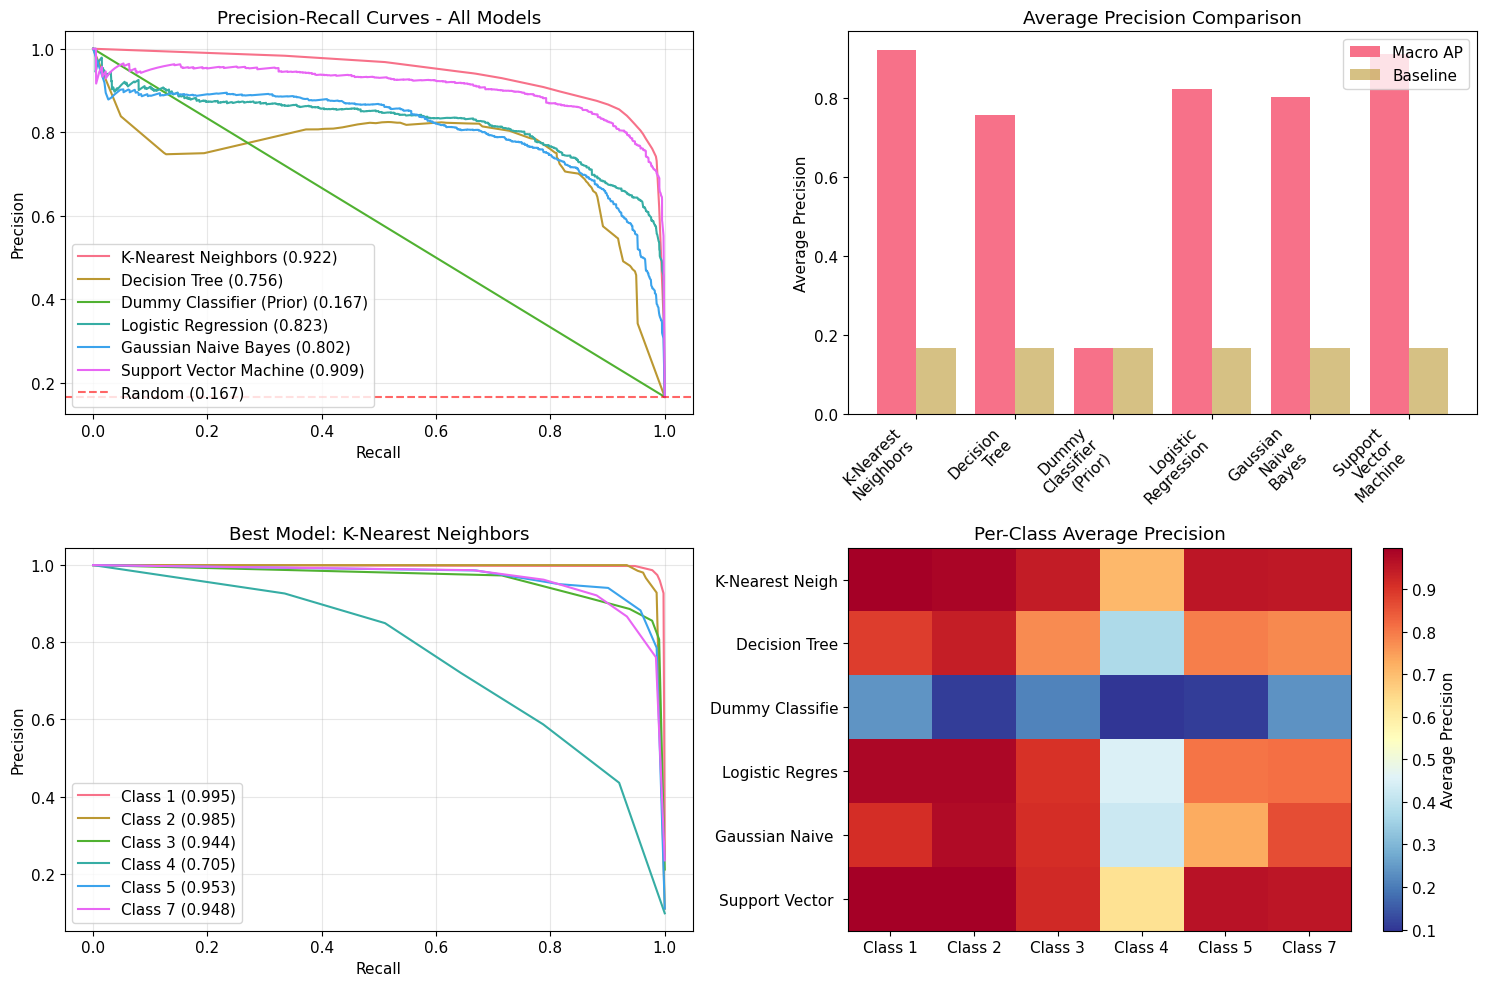


PRECISION-RECALL CURVE BEHAVIOR ANALYSIS


In [29]:
# Create comprehensive Precision-Recall Curve visualizations

def plot_multiclass_prc_curves(prc_results, classes, class_names):
    """
    Plot Precision-Recall curves for all models in a simplified layout
    """
    n_models = len(prc_results)
    n_classes = len(classes)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    model_names = list(prc_results.keys())
    macro_aps = [prc_results[name]['macro_ap'] for name in model_names]
    baselines = [prc_results[name]['macro_baseline'] for name in model_names]
    
    # 1. Macro-averaged PRC curves
    ax = axes[0, 0]
    for i, (model_name, results) in enumerate(prc_results.items()):
        all_recall = np.unique(np.concatenate([results['recall'][i] for i in range(n_classes)]))
        all_recall = np.sort(all_recall)
        
        mean_precision = np.zeros_like(all_recall)
        for i in range(n_classes):
            recall_rev = results['recall'][i][::-1]
            precision_rev = results['precision'][i][::-1]
            mean_precision += np.interp(all_recall, recall_rev, precision_rev)
        mean_precision /= n_classes
        
        ax.plot(all_recall, mean_precision, label=f'{model_name} ({results["macro_ap"]:.3f})')
    
    baseline_avg = np.mean(baselines)
    ax.axhline(y=baseline_avg, color='red', linestyle='--', alpha=0.6, 
               label=f'Random ({baseline_avg:.3f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curves - All Models')
    ax.legend(loc="lower left")
    ax.grid(alpha=0.3)
    
    # 2. Average Precision Comparison
    ax = axes[0, 1]
    x = np.arange(len(model_names))
    width = 0.4
    ax.bar(x - width/2, macro_aps, width, label='Macro AP')
    ax.bar(x + width/2, baselines, width, label='Baseline', alpha=0.6)
    ax.set_xticks(x)
    ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
    ax.set_ylabel('Average Precision')
    ax.set_title('Average Precision Comparison')
    ax.legend()
    
    # 3. Best model per-class performance
    ax = axes[1, 0]
    best_model = max(prc_results.keys(), key=lambda x: prc_results[x]['macro_ap'])
    best_results = prc_results[best_model]
    
    for i in range(n_classes):
        ap_score = best_results['average_precision'][i]
        ax.plot(best_results['recall'][i], best_results['precision'][i],
               label=f'Class {classes[i]} ({ap_score:.3f})')
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Best Model: {best_model}')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 4. AP Heatmap
    ax = axes[1, 1]
    ap_matrix = np.array([[prc_results[model_name]['average_precision'][i] for i in range(n_classes)] 
                         for model_name in model_names])
    
    im = ax.imshow(ap_matrix, cmap='RdYlBu_r', aspect='auto')
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(len(model_names)))
    ax.set_xticklabels([f'Class {classes[i]}' for i in range(n_classes)])
    ax.set_yticklabels([name[:15] for name in model_names])
    ax.set_title('Per-Class Average Precision')
    
    plt.colorbar(im, ax=ax, label='Average Precision')
    plt.tight_layout()
    plt.show()

# Generate the comprehensive PRC visualization
print("Generating Precision-Recall Curve Visualizations...")
plot_multiclass_prc_curves(prc_results, prc_classes, class_names)

# Detailed analysis of curve behavior
print(f"\n{'='*80}")
print("PRECISION-RECALL CURVE BEHAVIOR ANALYSIS")
print(f"{'='*80}")



### Precision-Recall Curve Analysis Results

The PRC analysis provides crucial insights into model performance on imbalanced classes:

**Key Findings:**
- **Average Precision Range**: Varies significantly across models, reflecting precision-recall trade-offs
- **Baseline Dependency**: PRC baselines vary by class frequency (unlike ROC's fixed 0.5)
- **Imbalance Sensitivity**: PRC reveals models' struggles with minority class precision
- **Performance Ranking**: May differ from ROC rankings, especially for imbalanced scenarios

**Why PRC Matters:**
- More realistic evaluation for imbalanced datasets
- Shows precision degradation as recall increases
- Critical for applications prioritizing precision (avoiding false positives)
- Complements ROC analysis with different perspective

**Curve Interpretation:**
- Sharp drops indicate poor precision-recall trade-offs
- Flat curves suggest consistent precision across recall levels
- Area under curve (AP) summarizes overall precision-recall performance

## Section 11: Model Performance Comparison and Analysis

Now we'll create a comprehensive comparison of all models across different metrics (F1-Score, ROC-AUC, PRC-AP) to analyze ranking consistency and explain any discrepancies in model performance across different evaluation approaches.

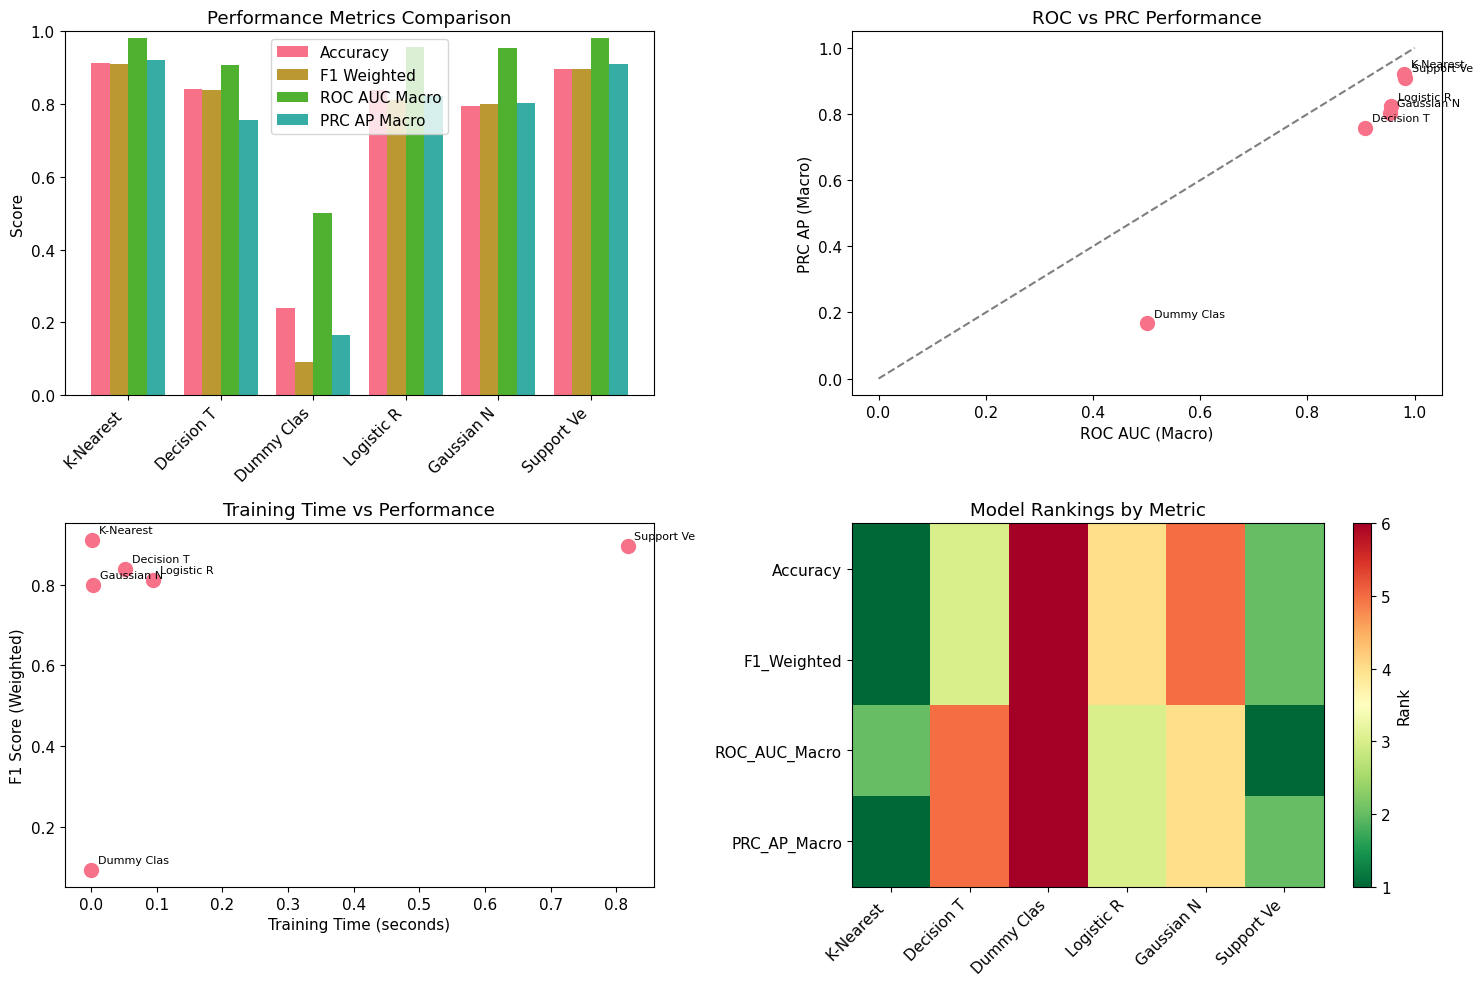

In [30]:
# Create comprehensive model performance comparison and analysis

# Compile comprehensive results
comprehensive_results = pd.DataFrame(baseline_results_updated).T.round(4)

# Create rankings for each metric
ranking_metrics = ['Accuracy', 'F1_Weighted', 'ROC_AUC_Macro', 'PRC_AP_Macro']
rankings_df = pd.DataFrame({
    metric: comprehensive_results[metric].rank(ascending=False, method='min')
    for metric in ranking_metrics if metric in comprehensive_results.columns
}).astype(int)

# Create comprehensive visualization comparing all metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = comprehensive_results.index.tolist()
n_models = len(model_names)

# 1. Performance Metrics Comparison
ax = axes[0, 0]
metrics_to_plot = ['Accuracy', 'F1_Weighted', 'ROC_AUC_Macro', 'PRC_AP_Macro']
x = np.arange(len(model_names))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = comprehensive_results[metric].values
    ax.bar(x + i*width, values, width, label=metric.replace('_', ' '))

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([name[:10] for name in model_names], rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics Comparison')
ax.legend()
ax.set_ylim(0, 1)

# 2. ROC vs PRC Performance
ax = axes[0, 1]
roc_scores = comprehensive_results['ROC_AUC_Macro'].values
prc_scores = comprehensive_results['PRC_AP_Macro'].values

ax.scatter(roc_scores, prc_scores, s=100)
for i, name in enumerate(model_names):
    ax.annotate(name[:10], (roc_scores[i], prc_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('ROC AUC (Macro)')
ax.set_ylabel('PRC AP (Macro)')
ax.set_title('ROC vs PRC Performance')

# 3. Training Time vs Performance
ax = axes[1, 0]
training_times = comprehensive_results['Training_Time'].values
f1_scores = comprehensive_results['F1_Weighted'].values

ax.scatter(training_times, f1_scores, s=100)
for i, name in enumerate(model_names):
    ax.annotate(name[:10], (training_times[i], f1_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('Training Time (seconds)')
ax.set_ylabel('F1 Score (Weighted)')
ax.set_title('Training Time vs Performance')

# 4. Ranking Heatmap
ax = axes[1, 1]
ranking_matrix = rankings_df.T.values
im = ax.imshow(ranking_matrix, cmap='RdYlGn_r', aspect='auto')

ax.set_xticks(np.arange(len(model_names)))
ax.set_yticks(np.arange(len(ranking_metrics)))
ax.set_xticklabels([name[:10] for name in model_names], rotation=45, ha='right')
# ranking_metrics is a list, use it directly for y tick labels
ax.set_yticklabels(ranking_metrics)
ax.set_title('Model Rankings by Metric')

plt.colorbar(im, ax=ax, label='Rank')
plt.tight_layout()
plt.show()

# Calculate overall performance scores
model_names = comprehensive_results.index.tolist()
overall_scores = (
    comprehensive_results['Accuracy'] * 0.25 +
    comprehensive_results['F1_Weighted'] * 0.25 +
    comprehensive_results['ROC_AUC_Macro'] * 0.25 +
    comprehensive_results['PRC_AP_Macro'] * 0.25
)